In [ ]:
import collections

import numpy as np
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/LAB3-20221109T160610Z-001/LCL-FullData/Cluster18data.csv')

In [ ]:
data['DateTime'] = pd.to_datetime(data['DateTime'])

In [ ]:
# Filter the DataFrame to include readings from 2011 to 2013
start_date1 = pd.to_datetime('2011-11-01')
end_date1 = pd.to_datetime('2013-02-28')
filtered_data = data[(data['DateTime'] >= start_date1) & (data['DateTime'] <= end_date1)]

In [ ]:
filtered_data['KWH/hh'] = filtered_data['KWH/hh'].astype(np.float32)

<ipython-input-5-9ed68d93464c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['KWH/hh'] = filtered_data['KWH/hh'].astype(np.float32)


In [ ]:
# Select 45 unique LCLids
lclid_list1 = filtered_data['LCLid'].unique()
selected_lclids1 = lclid_list1[:45]

# Filter data for the selected LCLids
filtered_data = filtered_data[filtered_data['LCLid'].isin(selected_lclids1)]

In [ ]:
filtered_data

,LCLid,stdorToU,DateTime,KWH/hh,cluster
0,MAC000105,Std,2011-12-13 10:00:00,1.297,17
1,MAC000105,Std,2011-12-13 10:30:00,0.977,17
2,MAC000105,Std,2011-12-13 11:00:00,0.783,17
3,MAC000105,Std,2011-12-13 11:30:00,0.711,17
4,MAC000105,Std,2011-12-13 12:00:00,0.775,17
...,...,...,...,...,...
358222,MAC004593,ToU,2013-02-27 22:00:00,2.105,17
358223,MAC004593,ToU,2013-02-27 22:30:00,2.079,17
358224,MAC004593,ToU,2013-02-27 23:00:00,3.139,17
358225,MAC004593,ToU,2013-02-27 23:30:00,1.169,17


In [ ]:
filtered_data = filtered_data.drop('cluster', axis=1)
filtered_data = filtered_data.drop('stdorToU', axis=1)
filtered_data = filtered_data.drop('DateTime', axis=1)
filtered_data = filtered_data.drop('LCLid', axis=1)

In [ ]:
filtered_data

,KWH/hh
0,1.297
1,0.977
2,0.783
3,0.711
4,0.775
...,...
358222,2.105
358223,2.079
358224,3.139
358225,1.169


In [ ]:
filtered_data.reset_index(drop=True, inplace=True)

In [ ]:
# Define the client window dataset function for a specific LCLid
def create_window_for_timeseries(client_data, window_size, step_size):
    client_windows = []
    client_targets = []
    num_readings = len(client_data)

    # Iterate over the readings using the sliding window
    for i in range(0, num_readings - window_size, step_size):
        window_start = i
        window_end = i + window_size - 1
        prediction_index = window_end + step_size

        # Extract the window and the prediction target
        window = client_data.iloc[window_start:window_end + 1]['KWH/hh'].values
        target = client_data.iloc[prediction_index]['KWH/hh']

        client_windows.append(window)
        client_targets.append(target)

    return client_windows, client_targets

In [ ]:
window_size = 336
step_size = 1


# Create the client dataset for the specific LCLid
X, Y = create_window_for_timeseries(filtered_data, window_size, step_size)

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import keras.backend as K

# Define the custom loss function
def mean_error(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mean_metrics(y_true, y_pred):
    return tf.reduce_mean((y_true - y_pred))

# Define the model
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(window_size,)))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

# Compile the model with the custom loss function
model.compile(loss=mean_error, optimizer='adam', metrics=mean_metrics)


In [ ]:
model.fit(X, Y, epochs=20, batch_size=12)

Epoch 1/20
13842/13842 [==============================] - 31s 2ms/step - loss: 0.2370 - mean_metrics: 0.0358
Epoch 2/20
13842/13842 [==============================] - 27s 2ms/step - loss: 0.2171 - mean_metrics: 0.0320
Epoch 3/20
13842/13842 [==============================] - 29s 2ms/step - loss: 0.2134 - mean_metrics: 0.0327
Epoch 4/20
13842/13842 [==============================] - 28s 2ms/step - loss: 0.2113 - mean_metrics: 0.0328
Epoch 5/20
13842/13842 [==============================] - 28s 2ms/step - loss: 0.2101 - mean_metrics: 0.0334
Epoch 6/20
13842/13842 [==============================] - 28s 2ms/step - loss: 0.2091 - mean_metrics: 0.0331
Epoch 7/20
13842/13842 [==============================] - 28s 2ms/step - loss: 0.2082 - mean_metrics: 0.0337
Epoch 8/20
13842/13842 [==============================] - 28s 2ms/step - loss: 0.2070 - mean_metrics: 0.0339
Epoch 9/20
13842/13842 [==============================] - 28s 2ms/step - loss: 0.2061 - mean_metrics: 0.0345
Epoch 10/20
13842/1

In [ ]:
filtered_data44 = filtered_data2[filtered_data2['LCLid'] == 'MAC004593']

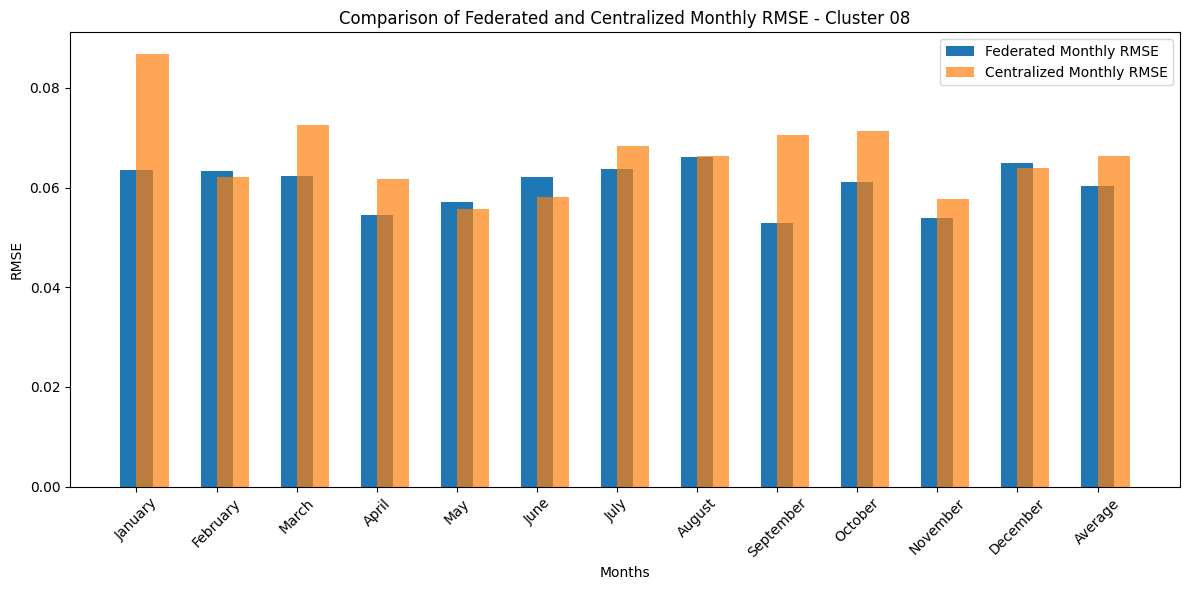

In [ ]:
import matplotlib.pyplot as plt

months = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December", "Average"
]

federated_rmse = [
    0.0636, 0.0633, 0.0623, 0.0544, 0.0570, 0.0621,
    0.0638, 0.0662, 0.0528, 0.0611, 0.0539, 0.0650, 0.0604
]

centralized_rmse = [
    0.0868, 0.0622, 0.0725, 0.0618, 0.0557, 0.0581,
    0.0684, 0.0663, 0.0705, 0.0713, 0.0576, 0.0640, 0.0663
]

# Plotting the data
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(months))

plt.bar(index, federated_rmse, width=bar_width, label='Federated Monthly RMSE', align='center')
plt.bar(index, centralized_rmse, width=bar_width, label='Centralized Monthly RMSE', align='edge', alpha=0.7)

plt.xlabel('Months')
plt.ylabel('RMSE')
plt.title('Comparison of Federated and Centralized Monthly RMSE - Cluster 08')
plt.xticks(index, months, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()



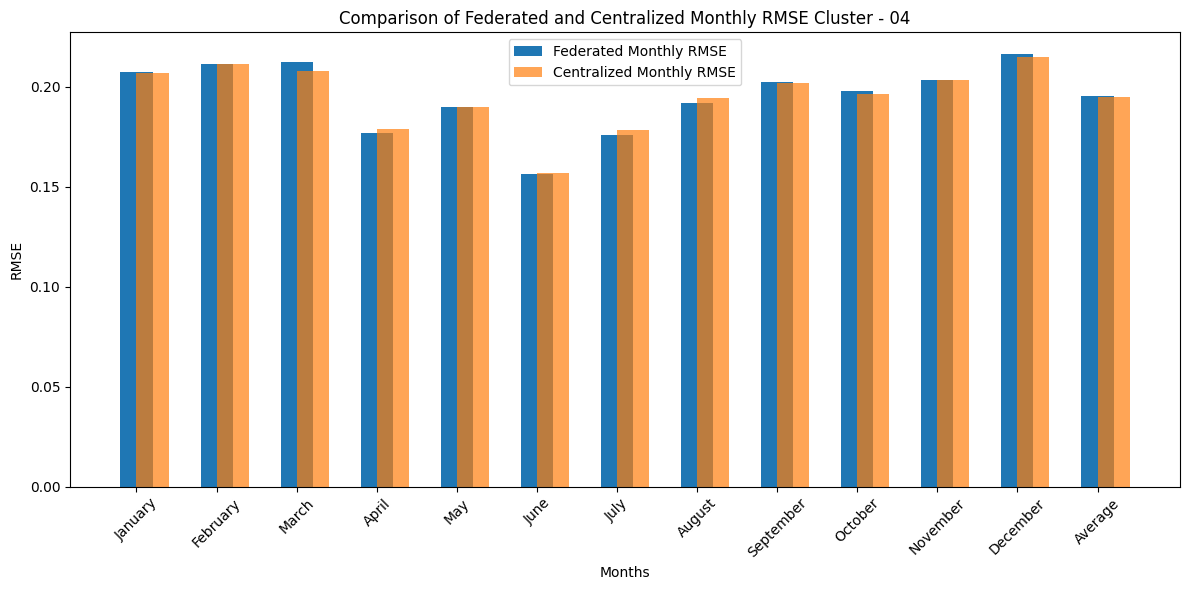

In [ ]:
import matplotlib.pyplot as plt

months = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December", "Average"
]

federated_rmse = [
    0.2073, 0.2114, 0.2123, 0.1771, 0.1902, 0.1563,
    0.1758, 0.1920, 0.2027, 0.1978, 0.2036, 0.2165, 0.1953
]

centralized_rmse = [
    0.2069, 0.2114, 0.2078, 0.1789, 0.1899, 0.1570,
    0.1785, 0.1943, 0.2022, 0.1963, 0.2037, 0.2152, 0.195175
]

# Plotting the data
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(months))

plt.bar(index, federated_rmse, width=bar_width, label='Federated Monthly RMSE', align='center')
plt.bar(index, centralized_rmse, width=bar_width, label='Centralized Monthly RMSE', align='edge', alpha=0.7)

plt.xlabel('Months')
plt.ylabel('RMSE')
plt.title('Comparison of Federated and Centralized Monthly RMSE Cluster - 04')
plt.xticks(index, months, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


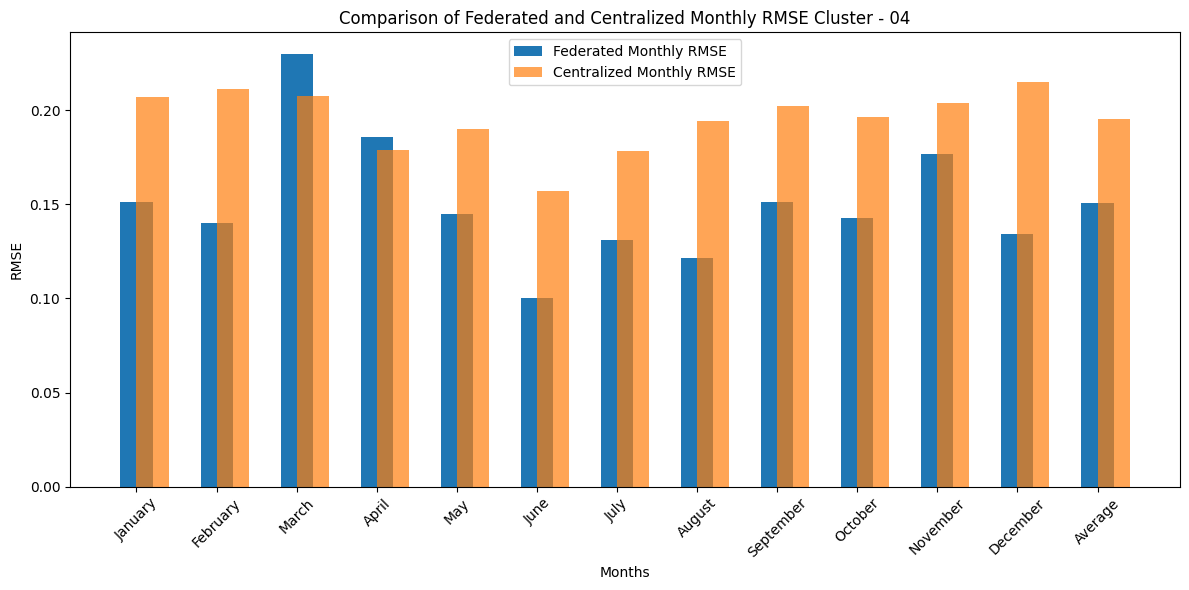

In [ ]:
import matplotlib.pyplot as plt

months = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December", "Average"
]

federated_rmse = [0.1512,
0.1403,
0.2300,
0.1860,
0.1450,
0.1004,
0.1311,
0.1217,
0.1515,
0.1426,
0.1768,
0.1342,
0.1509
]

centralized_rmse = [0.2069,
0.2114,
0.2078,
0.1789,
0.1899,
0.1570,
0.1785,
0.1943,
0.2022,
0.1963,
0.2037,
0.2152,
0.195175
]

# Plotting the data
plt.figure(figsize=(12, 6))
bar_width = 0.4
index = range(len(months))

plt.bar(index, federated_rmse, width=bar_width, label='Federated Monthly RMSE', align='center')
plt.bar(index, centralized_rmse, width=bar_width, label='Centralized Monthly RMSE', align='edge', alpha=0.7)

plt.xlabel('Months')
plt.ylabel('RMSE')
plt.title('Comparison of Federated and Centralized Monthly RMSE Cluster - 04')
plt.xticks(index, months, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Testing STLF
import datetime

teststart_date = pd.to_datetime('2014-01-01')
testend_date = pd.to_datetime('2014-01-08')

interval = datetime.timedelta(minutes=30)
num_datasets = 48

test_data = []  # List to store the test_data datasets

for i in range(num_datasets):
    start_time = teststart_date + i * interval
    end_time = testend_date + i * interval

    test_data_i = filtered_data44[
        (filtered_data44['DateTime'] >= start_time) & (filtered_data44['DateTime'] <= end_time)
    ]

    test_data.append(test_data_i)

In [ ]:
test_data[1]

,LCLid,stdorToU,DateTime,KWH/hh,cluster
372968,MAC004593,ToU,2014-01-01 00:30:00,0.988,17
372969,MAC004593,ToU,2014-01-01 01:00:00,0.831,17
372970,MAC004593,ToU,2014-01-01 01:30:00,0.816,17
372971,MAC004593,ToU,2014-01-01 02:00:00,0.772,17
372972,MAC004593,ToU,2014-01-01 02:30:00,1.005,17
...,...,...,...,...,...
373300,MAC004593,ToU,2014-01-07 22:30:00,0.740,17
373301,MAC004593,ToU,2014-01-07 23:00:00,0.981,17
373302,MAC004593,ToU,2014-01-07 23:30:00,0.684,17
373303,MAC004593,ToU,2014-01-08 00:00:00,0.557,17


In [ ]:
for i in range(num_datasets):
  test_data[i] = test_data[i].drop('cluster', axis=1)
  test_data[i] = test_data[i].drop('stdorToU', axis=1)
  test_data[i] = test_data[i].drop('DateTime', axis=1)
  test_data[i] = test_data[i].drop('LCLid', axis=1)

In [ ]:
for i in range(num_datasets):
  test_data[i].reset_index(drop=True, inplace=True)
  test_data[i]['KWH/hh'] = test_data[i]['KWH/hh'].astype(np.float32)

test_data[2]

,KWH/hh
0,0.831
1,0.816
2,0.772
3,1.005
4,0.971
...,...
332,0.981
333,0.684
334,0.557
335,0.311


In [ ]:
X_test = []
Y_test = []


for i in range(num_datasets):
  x, y = create_window_for_timeseries(test_data[i], window_size, step_size)
  X_test.append(x)
  Y_test.append(y)

In [ ]:
for i in range(num_datasets):
  X_test = np.array(X_test)
  Y_test = np.array(Y_test)

In [ ]:
loss_list = []
mae_list = []

# Evaluate the model for each dataset
for i in range(num_datasets):
    loss, mae = model.evaluate(X_test[i], Y_test[i])
    loss_list.append(loss)
    mae_list.append(mae)
    print("Loss:", loss)



1/1 [==============================] - 0s 159ms/step - loss: 0.1226 - mean_metrics: -0.1226
Loss: 0.12258303165435791
1/1 [==============================] - 0s 27ms/step - loss: 0.2936 - mean_metrics: -0.2936
Loss: 0.29363518953323364
1/1 [==============================] - 0s 93ms/step - loss: 0.1476 - mean_metrics: -0.1476
Loss: 0.14758913218975067
1/1 [==============================] - 0s 43ms/step - loss: 0.2040 - mean_metrics: -0.2040
Loss: 0.2040344625711441
1/1 [==============================] - 0s 78ms/step - loss: 0.0674 - mean_metrics: -0.0674
Loss: 0.0673862099647522
1/1 [==============================] - 0s 50ms/step - loss: 0.0886 - mean_metrics: -0.0886
Loss: 0.08859816193580627
1/1 [==============================] - 0s 65ms/step - loss: 0.0734 - mean_metrics: -0.0734
Loss: 0.07341280579566956
1/1 [==============================] - 0s 42ms/step - loss: 0.1005 - mean_metrics: -0.1005
Loss: 0.10048431158065796
1/1 [==============================] - 0s 26ms/step - loss: 0.057